# Broccoli PIO AppendCS simulation env

## Dev env


In [ ]:
# 初回だけ実行
# %pip install pandas
# %pip install wavedrom
# %pip install svgwrite
# %pip install rp2040-pio-emulator@git+https://github.com/NathanY3G/rp2040-pio-emulator
# %pip install adafruit-circuitpython-pioasm

## Sim + Analysis

Pythonを使ったデバッグ環境向け。このSectionの内容は最終的にProductに持っていく必要はない

In [ ]:
from dataclasses import dataclass
import json
from typing import Any, Callable, Dict, List, Optional
import pandas as pd
from collections import deque
import itertools
import adafruit_pioasm
import pioemu
import wavedrom
import svgwrite


def to_hex_u32(x: int) -> str:
    """32bit符号なし整数を16進数文字列に変換する"""
    return f"0x{(x& 0xffffffff):08X}"


def to_hex_str_arr(src: List[int]) -> List[str]:
    return [to_hex_u32(x) for x in src]


@dataclass
class EmulateResult:
    """PIOのエミュレーション結果を格納するクラス"""

    program_str: str
    test_cycles: int
    tx_fifo_entries: List[int]
    run_states_df: pd.DataFrame
    rx_fifo: List[int]
    received_from_rx_fifo: List[int]
    wavedrom_src: str
    wave_svg: svgwrite.drawing.Drawing


def emulate_pio(
    program_str: str,
    test_cycles: int,
    tx_fifo_entries: List[int] = [],
    dequeue_period_cyc: int = 0,
) -> EmulateResult:
    """PIOのsimulationを行う"""

    # emulation
    opcodes = adafruit_pioasm.assemble(program_str)
    generator = pioemu.emulate(
        opcodes=opcodes,
        stop_when=lambda _, state: state.clock > test_cycles,
        initial_state=pioemu.State(
            clock=0,
            program_counter=0,
            transmit_fifo=deque(tx_fifo_entries),
            receive_fifo=deque([]),
            x_register=0,
            y_register=0,
        ),
        shift_isr_right=False,
        shift_osr_right=True,
    )

    # run
    run_states = []
    received_data = []
    dma_dequeue_ready_cnt = 0  # dequeue_period_cycより大きければDequeue可能
    for before, after in itertools.islice(generator, test_cycles):
        run_states.append(after.__dict__)
        # dequeue
        dma_dequeue_ready_cnt += 1
        if (dma_dequeue_ready_cnt > dequeue_period_cyc) and (
            len(before.receive_fifo) > 0
        ):
            received_data.append(after.receive_fifo.popleft())
            dma_dequeue_ready_cnt = 0

    run_states_df = pd.DataFrame.from_records(run_states)
    rx_fifo = list(run_states_df[-1:]["receive_fifo"].values[0])

    # 欲しいデータ抽出

    def get_insert_idx() -> int:
        """DataFrameに新しい列を挿入するためのインデックスを返す"""

        dst = get_insert_idx.insert_idx  # increment前を返す
        get_insert_idx.insert_idx += 1
        return dst

    get_insert_idx.insert_idx = 0

    run_states_df.insert(
        get_insert_idx(),
        "cyc",
        run_states_df["clock"],
    )
    run_states_df.insert(
        get_insert_idx(),
        "pc",
        run_states_df["program_counter"],
    )
    run_states_df.insert(
        get_insert_idx(),
        "inst",
        run_states_df["pc"].map(lambda pc: to_hex_u32(opcodes[pc])),
    )
    run_states_df.insert(
        get_insert_idx(), "x", run_states_df["x_register"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(), "y", run_states_df["y_register"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(),
        "isr",
        run_states_df["input_shift_register"].map(lambda sr: to_hex_u32(sr.contents)),
    )
    run_states_df.insert(
        get_insert_idx(),
        "osr",
        run_states_df["output_shift_register"].map(lambda sr: to_hex_u32(sr.contents)),
    )
    run_states_df.insert(
        get_insert_idx(), "pindirs", run_states_df["pin_directions"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(), "pins", run_states_df["pin_values"].map(to_hex_u32)
    )
    run_states_df.insert(
        get_insert_idx(),
        "txfifo_head",
        run_states_df["transmit_fifo"].map(
            lambda data: to_hex_u32(data[0]) if len(data) > 0 else None
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "txfifo_remain",
        run_states_df["transmit_fifo"].map(lambda data: len(data)),
    )
    run_states_df.insert(
        get_insert_idx(),
        "rxfifo_tail",
        run_states_df["receive_fifo"].map(
            lambda data: to_hex_u32(data[-1]) if len(data) > 0 else None
        ),
    )
    run_states_df.insert(
        get_insert_idx(),
        "rxfifo_remain",
        run_states_df["receive_fifo"].map(lambda data: len(data)),
    )

    def to_wavedrom_signal(
        df: pd.DataFrame,
        col: str,
        replace_f: Optional[Callable[[Any, Any], Any]] = None,
    ) -> Dict[str, Any]:
        """DataFrameの列をWavedromの信号に変換する"""
        src = df[col].map(lambda x: "1" if x else "0").to_list()
        dst_wave = []

        prev_data = None
        for entry in src:
            # 差し替え関数あるなら任せる
            if replace_f is not None:
                dst_wave.append(replace_f(prev_data, entry))
            elif prev_data == entry:
                dst_wave.append(".")
            else:
                dst_wave.append(entry)
            # 一つ前のデータを保存
            prev_data = entry
        return {"name": col, "wave": "".join(dst_wave)}

    def to_wavedrom_data(df: pd.DataFrame, col: str) -> Dict[str, Any]:
        """DataFrameの列をWavedromの信号に変換する"""
        src = df[col].to_list()
        dst_wave = []
        dst_data = []

        prev_data = None
        for entry in src:
            # Noneのときは最初から一致してしまう
            if entry is None:
                dst_wave.append("x")
            elif prev_data == entry:
                dst_wave.append(".")
            else:
                dst_wave.append("=")
                dst_data.append(
                    hex(
                        int(entry, 16),
                    ).replace("0x", "")
                    if isinstance(entry, str)
                    else entry
                )  # 長いので縮める, str|intの場合分け
            # 一つ前のデータを保存
            prev_data = entry
        return {"name": col, "wave": "".join(dst_wave), "data": dst_data}

    wavedrom_src = json.dumps(
        {
            "signal": [
                [
                    "pio",
                    [
                        "ctrl",
                        to_wavedrom_data(run_states_df, "cyc"),
                        to_wavedrom_data(run_states_df, "pc"),
                        to_wavedrom_data(run_states_df, "inst"),
                        [
                            "fifo",
                            [
                                "tx",
                                to_wavedrom_data(run_states_df, "txfifo_head"),
                                to_wavedrom_data(run_states_df, "txfifo_remain"),
                            ],
                            [
                                "rx",
                                to_wavedrom_data(run_states_df, "rxfifo_tail"),
                                to_wavedrom_data(run_states_df, "rxfifo_remain"),
                            ],
                        ],
                    ],
                    {},
                    [
                        "regs",
                        [
                            "scratch",
                            to_wavedrom_data(run_states_df, "x"),
                            to_wavedrom_data(run_states_df, "y"),
                        ],
                        [
                            "fifo",
                            to_wavedrom_data(run_states_df, "isr"),
                            to_wavedrom_data(run_states_df, "osr"),
                        ],
                        [
                            "pinout",
                            to_wavedrom_data(run_states_df, "pindirs"),
                            to_wavedrom_data(run_states_df, "pins"),
                        ],
                    ],
                ],
            ]
        }
    )
    wave_svg = wavedrom.render(wavedrom_src)

    return EmulateResult(
        program_str=program_str,
        test_cycles=test_cycles,
        tx_fifo_entries=tx_fifo_entries,
        run_states_df=run_states_df,
        rx_fifo=rx_fifo,
        received_from_rx_fifo=received_data,
        wavedrom_src=wavedrom_src,
        wave_svg=wave_svg,
    )

## PIO Program Definition

実機に移植が必要な部分

In [33]:
from typing import List, Optional, Union
import pandas as pd
from enum import Enum, auto
from IPython.display import display
from pathlib import Path
import pandas as pd


def bit_on(bit_pos: int) -> int:
    """指定したbitだけ1の値"""
    return 0x01 << bit_pos


def sim_broccoli(
    pio_file: str,
    tx_fifo_entries: List[int],
    export_file_name: Optional[str] = None,
    test_cycles: int = 150,
    dequeue_period_cyc: int = 16,
) -> EmulateResult:
    """デバッグ用。Simの実行と結果表示を行う"""

    # PIO Assembler
    program = Path(pio_file).read_text(encoding="utf-8")
    result = emulate_pio(
        program,
        test_cycles=test_cycles,
        tx_fifo_entries=tx_fifo_entries,
        dequeue_period_cyc=dequeue_period_cyc,
    )

    pd.set_option("display.max_rows", 100)
    pd.set_option("display.max_columns", 100)

    # output logs
    if export_file_name is not None:
        Path("dst").mkdir(exist_ok=True)
        Path(f"dst/{export_file_name}").mkdir(exist_ok=True)
        Path(f"dst/{export_file_name}/{pio_file}").write_text(program, encoding="utf-8")
        Path(f"dst/{export_file_name}/tx_fifo.json").write_text(
            json.dumps(result.tx_fifo_entries), encoding="utf-8"
        )
        Path(f"dst/{export_file_name}/rx_fifo.json").write_text(
            json.dumps(result.rx_fifo), encoding="utf-8"
        )
        Path(f"dst/{export_file_name}/wave.json").write_text(result.wavedrom_src)
        result.run_states_df.to_csv(f"dst/{export_file_name}/run_states.csv")
        result.wave_svg.saveas(f"dst/{export_file_name}/wave.svg")

    print(
        f"tx_fifo_entries: {len(result.tx_fifo_entries)} {to_hex_str_arr(result.tx_fifo_entries)}"
    )
    print(f"received_from_rx_fifo: {to_hex_str_arr(result.received_from_rx_fifo)}")
    print(f"rx_fifo: {to_hex_str_arr(result.rx_fifo)}")
    display(result.wave_svg)

    return result

----

# Command Debug

pio の TX/RX Fifoにデータを流し込む想定シーケンスを動かしてみる。部分的にProductへの移植が必要になると思われる

### Auto Block Erase

src_data_list: ['0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
expect_data_list: ['0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
tx_fifo_entries: 9 ['0x00000000', '0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
received_from_rx_fifo: ['0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
rx_fifo: []


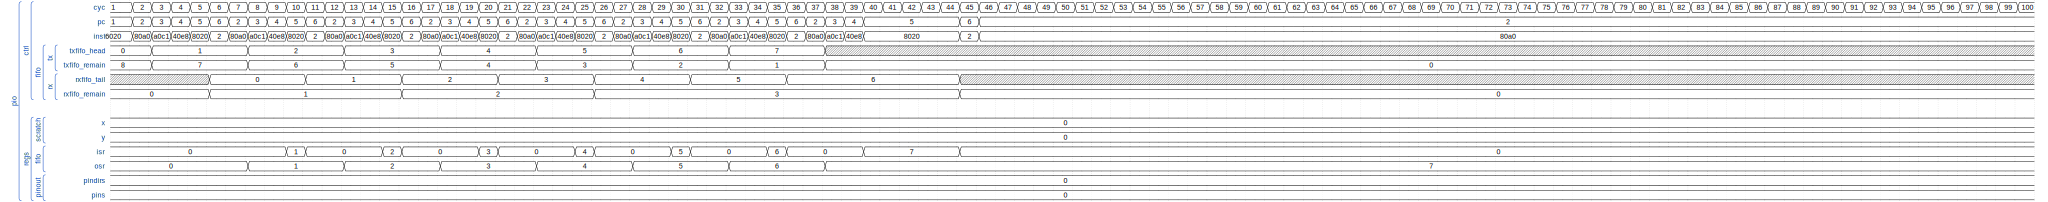

src_data_list: ['0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
expect_data_list: ['0x00000100', '0x00000101', '0x00000102', '0x00000103', '0x00000104', '0x00000105', '0x00000106', '0x00000107']
tx_fifo_entries: 9 ['0x00000001', '0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
received_from_rx_fifo: ['0x00000100', '0x00000101', '0x00000102', '0x00000103', '0x00000104', '0x00000105', '0x00000106', '0x00000107']
rx_fifo: []


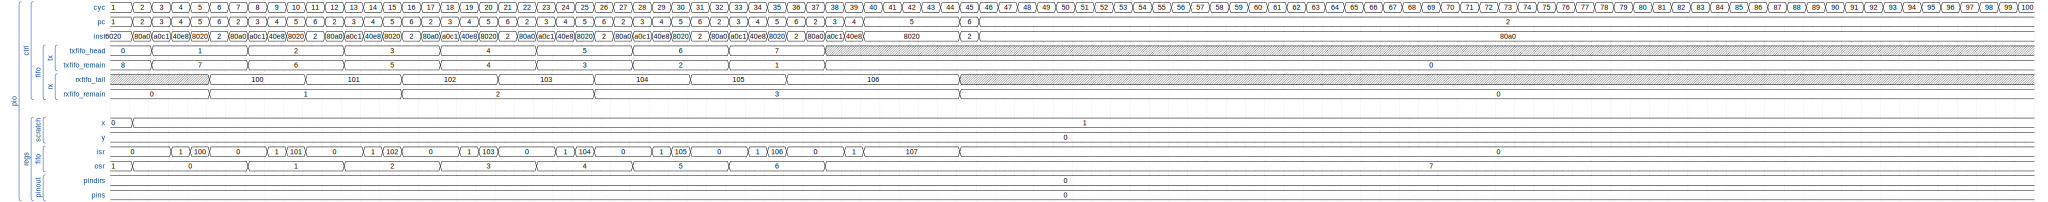

src_data_list: ['0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
expect_data_list: ['0x00000200', '0x00000201', '0x00000202', '0x00000203', '0x00000204', '0x00000205', '0x00000206', '0x00000207']
tx_fifo_entries: 9 ['0x00000002', '0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
received_from_rx_fifo: ['0x00000200', '0x00000201', '0x00000202', '0x00000203', '0x00000204', '0x00000205', '0x00000206', '0x00000207']
rx_fifo: []


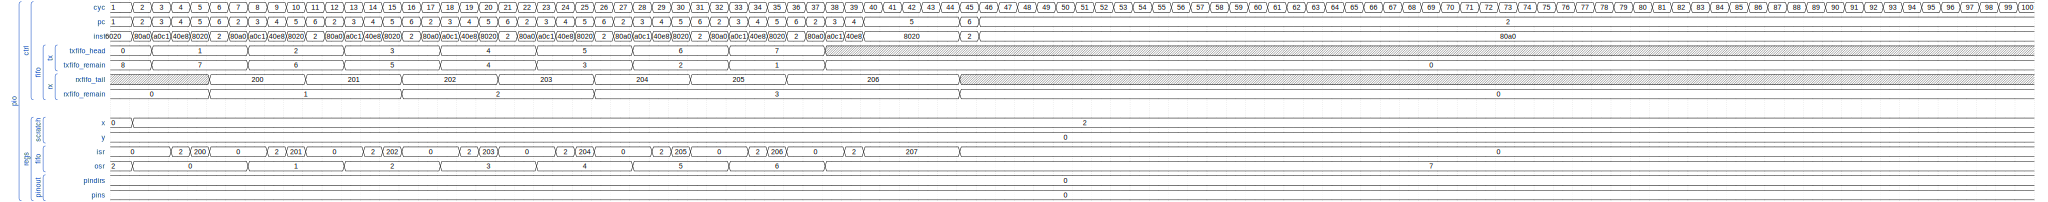

src_data_list: ['0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
expect_data_list: ['0x00000300', '0x00000301', '0x00000302', '0x00000303', '0x00000304', '0x00000305', '0x00000306', '0x00000307']
tx_fifo_entries: 9 ['0x00000003', '0x00000000', '0x00000001', '0x00000002', '0x00000003', '0x00000004', '0x00000005', '0x00000006', '0x00000007']
received_from_rx_fifo: ['0x00000300', '0x00000301', '0x00000302', '0x00000303', '0x00000304', '0x00000305', '0x00000306', '0x00000307']
rx_fifo: []


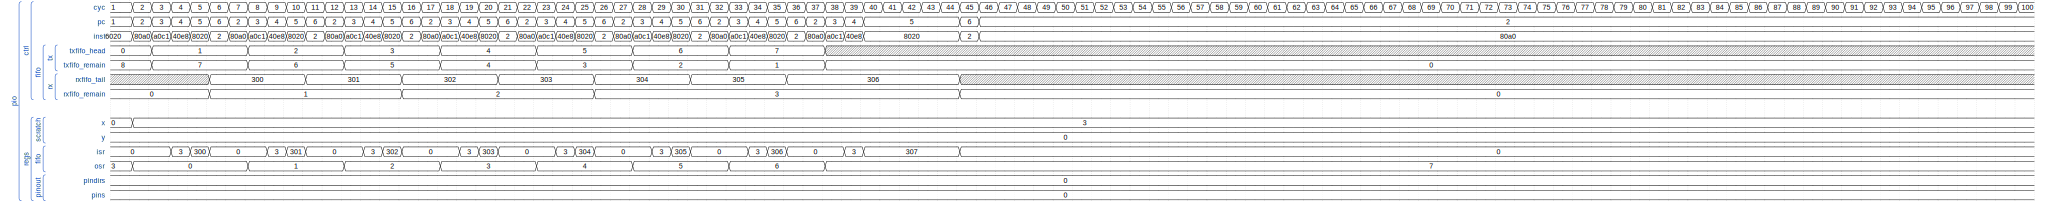

In [34]:
for select_cs in range(0, 4):
    testdata_length = 8
    src_data_list = [i & 0xFF for i in range(0, testdata_length)]
    # cs | 1byteごとの結果が来る
    expect_data_list = [(select_cs << 8) | d for d in src_data_list]

    print(f"src_data_list: {to_hex_str_arr(src_data_list)}")
    print(f"expect_data_list: {to_hex_str_arr(expect_data_list)}")

    tx_fifo_entries = list(
        itertools.chain.from_iterable(
            [
                [
                    # ceb[1:0] を最初に送る
                    select_cs,
                ],
                # 以後データ
                src_data_list,
            ]
        )
    )

    ret = sim_broccoli(
        pio_file="broccoli-pio-append-cs.pio",
        tx_fifo_entries=tx_fifo_entries,
        export_file_name=f"cs_={select_cs:02X}",
        test_cycles=100,
        dequeue_period_cyc=10,
    )

    # verify
    for i in range(0, testdata_length):
        assert ret.received_from_rx_fifo[i] == expect_data_list[i], f"i={i}"
        assert (ret.received_from_rx_fifo[i] >> 8) == select_cs, f"i={i}"
        assert (ret.received_from_rx_fifo[i] & 0xFF) == src_data_list[i], f"i={i}"
